# Chapter 15 - Processing Sequence using RNN and CNN

- RNN are not only types of neural network capable of handling sequence data.
- RNN is like feedforward network except it has a connection backward
- Output from RNN for single instance
    $ y_{t} = \phi (W_{x}^{T} x_{t} + W_{y}^T y_{(t-1)} + b)$
- Many reachers prefer to use "tanh" activation function for RNN than ReLU function

## Memory Cell
- Output of each recurrent neuron at time step "t" is function of input from previous time step - you could say it is a memory.
- A part of neural network that preserves some state across time step is called Memory Cell.
- Single recurrent neuron is basic cell capable of learning only short patterns (about 10 steps long but varies depending on task)
- In general a cell state at anytime "t" is denoted as $h_{t}$ (hidden state)

## Input & Output Sequence
- RNN can take sequence of input and produce sequence of output
- Sequence to Sequence: network is useful in predicting timeseries such as stock market prices
- Sequence to Vector: You can also feed network with series of input with output for last one; e.g. movie rating based on comments
- Vector to Sequence: You can feed same input vector again and again and let output be the sequence; e.g. captioning an image
- Lastly we have sequence to vector network called encoders, followed by vector to sequence network called Decoders; used for translating one language to another. Encoder converts input in one language to vector and decoders convert vectorsto differnt language

## Training RNN on Time series

#### Since RNN takes longer than CNN or Dense networks - we will use Collab workbook for this

In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:

X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

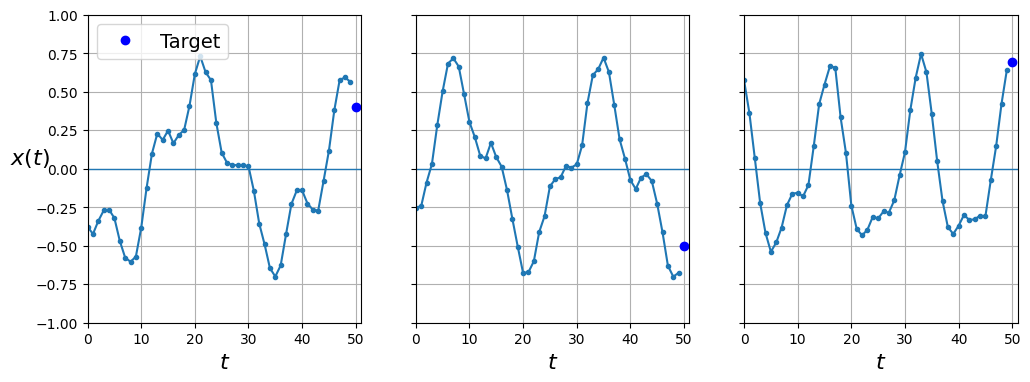

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

### Computing some baselines

In [7]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mse(y_valid, y_pred))

np.float32(0.020211367)

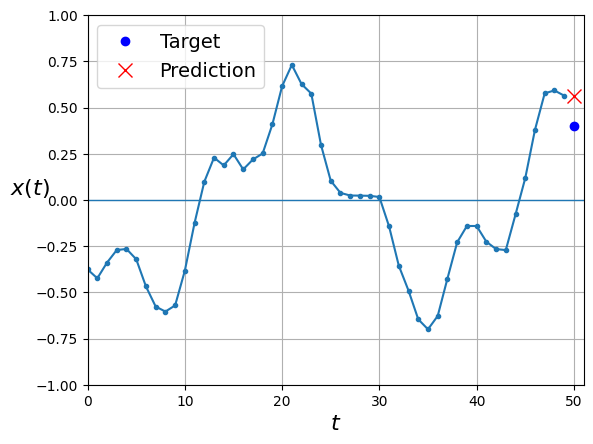

In [8]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Making prediction using linear regression

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0560 - val_loss: 0.0196
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0162 - val_loss: 0.0101
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0075
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

In [10]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033


0.003505193628370762

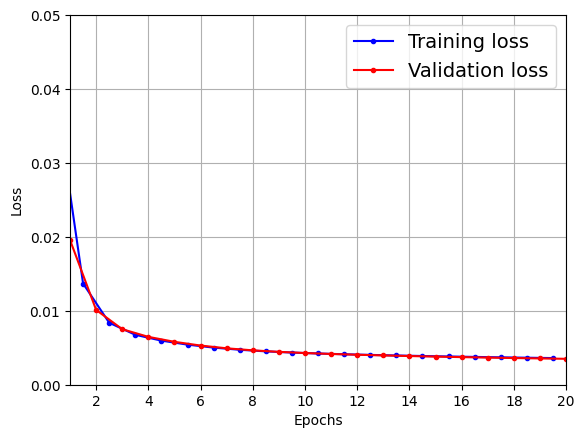

In [11]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


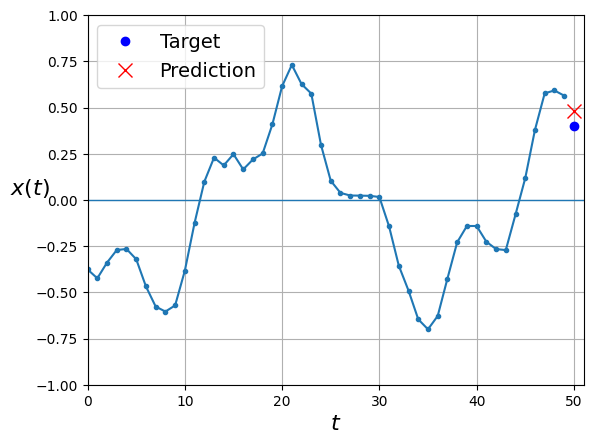

In [12]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Using Simple RNN

In [13]:
# this is the simplest RNN - single layer with single neuron. No need to specify length of input sequence
# by default simple RNN uses tanh activation function
# by default recurrent layers in keras only return final output. To make them output at every timestep, set return_sequence=True
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)

In [15]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2319 - val_loss: 0.0306
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0284 - val_loss: 0.0231
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0219 - val_loss: 0.0185
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0180 - val_loss: 0.0157
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0155 - val_loss: 0.0138
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138 - val_loss: 0.0126
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0127 - val_loss: 0.0118
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0121 - val_loss: 0.0113
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

In [16]:
model.evaluate(X_valid, y_valid)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110


0.010924581438302994

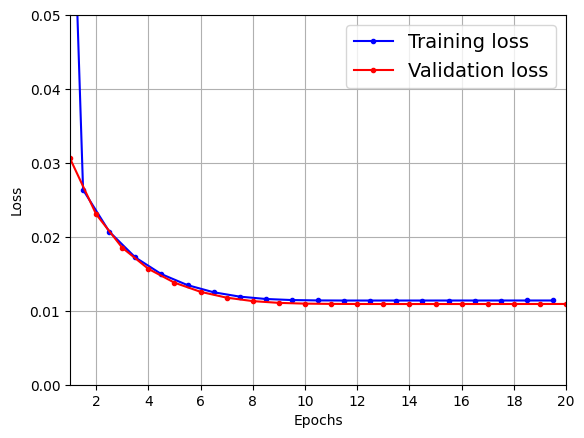

In [17]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


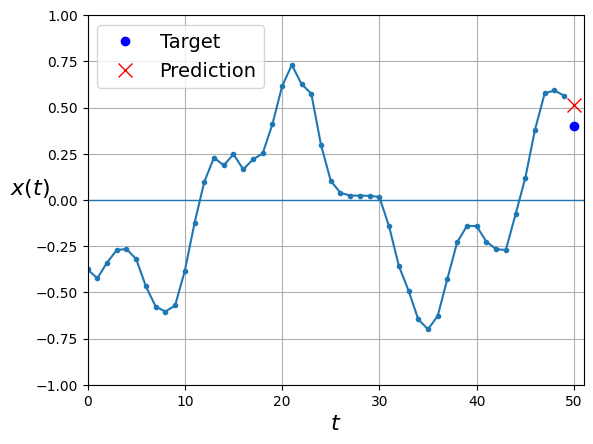

In [18]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Deep RNN

In [19]:
# Below will take ages to run
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.1291 - val_loss: 0.0089
Epoch 2/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0080 - val_loss: 0.0068
Epoch 3/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0055 - val_loss: 0.0058
Epoch 4/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 5/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 6/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0037 - val_loss: 0.0042
Epoch 7/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0036 - val_loss: 0.0039
Epoch 8/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 9/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 10/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 11/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 12/20
219/219 ━━━━━━━━━━━━━━━━━━━━ 